In [2]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(patchwork)
  library(GenomicRanges)
  library(rtracklayer)
  library(Seurat)
  library(Signac)
  library(dplyr)
  library(Pando)
  library(BSgenome.Hsapiens.UCSC.hg38)
})

In [3]:
seurat_object <- readRDS('{PATH_1}')

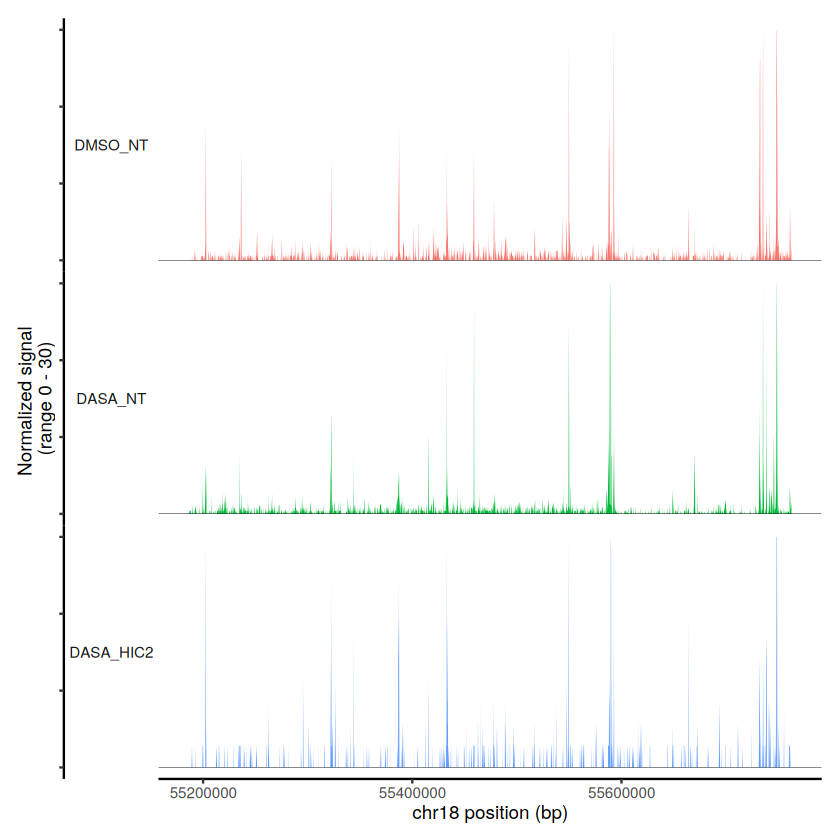

In [4]:
cov_plot <- CoveragePlot(
  object = seurat_object,
  region = "chr18-55186072-55762857",
  annotation = FALSE,
  peaks = FALSE,
  links = FALSE,
  # extend.upstream = 5000,
  # extend.downstream = 5000,
  ymax = 30
)
cov_plot

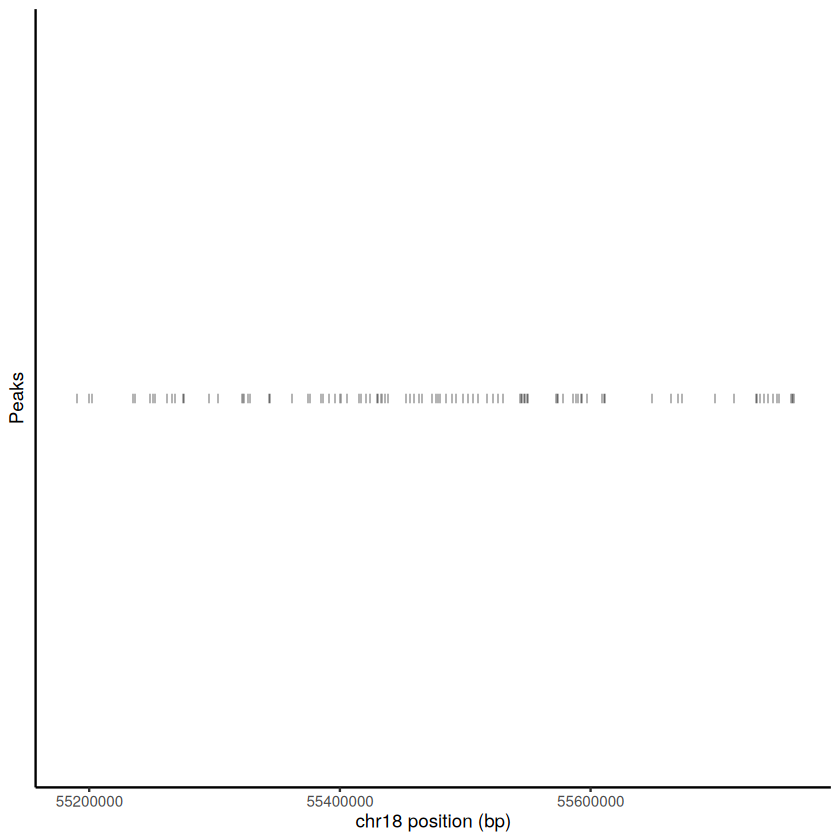

In [5]:
peak_plot <- PeakPlot(
  object = seurat_object,
  region = "chr18-55186072-55762857"
)
peak_plot

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_segment()`).”


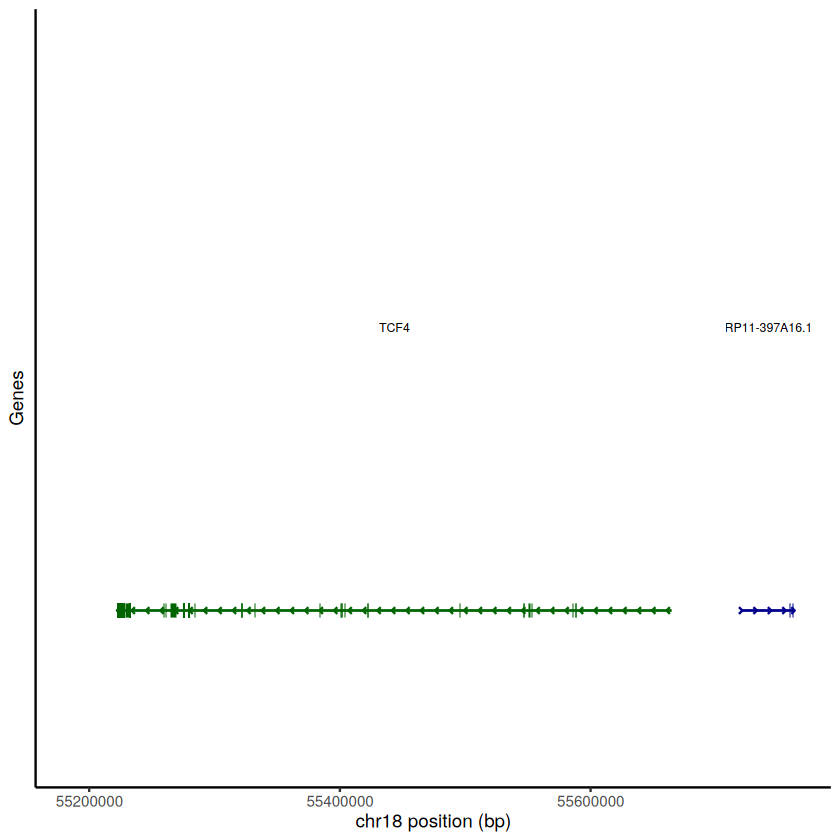

In [6]:
gene_plot <- AnnotationPlot(
  object = seurat_object,
  region = "chr18-55186072-55762857"
)
gene_plot

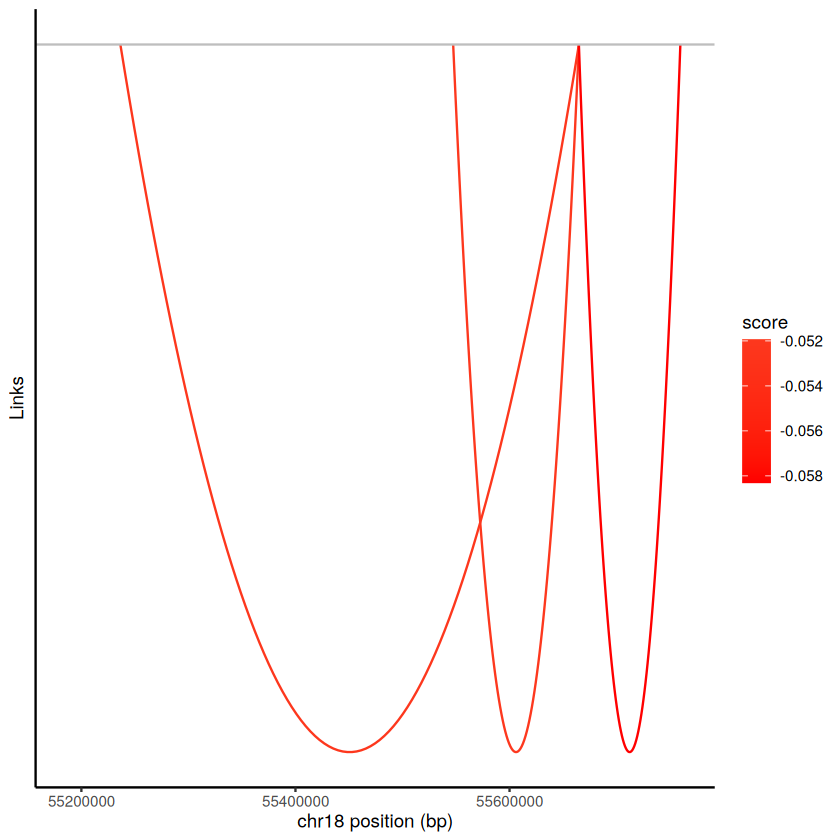

In [7]:
link_plot <- LinkPlot(
  object = seurat_object,
  region = "chr18-55186072-55762857"
)
link_plot

In [8]:
coefs <- read.csv('{PATH_2}', row.names = 1)
subset_coefs <- coefs[(coefs$target == "TCF4") & (coefs$pval < 0.05), ] 
regulatory_regions <- data.frame(
  start = as.numeric(sub(".*-(\\d+)-\\d+", "\\1", subset_coefs$region)),
  end = as.numeric(sub(".*-\\d+-(\\d+)", "\\1", subset_coefs$region)),
  type = ifelse(subset_coefs$corr < 0, "Repressing", "Activating"),
  name = subset_coefs$tf
)

In [9]:
regulatory_regions_activating <- regulatory_regions[regulatory_regions$type == "Activating", ]
regulatory_regions_activating


,start,end,type,name
,<dbl>,<dbl>,<chr>,<chr>
5,55235918,55236927,Activating,KLF13
6,55261775,55262816,Activating,ZNF117
8,55295048,55295939,Activating,ZNF33B
10,55322346,55322861,Activating,ZFPM2
12,55375696,55376626,Activating,MXD4
14,55386395,55387235,Activating,ZFPM2
16,55415055,55415969,Activating,MEF2A
19,55433174,55434244,Activating,NFAT5
27,55492395,55493349,Activating,ZFPM1


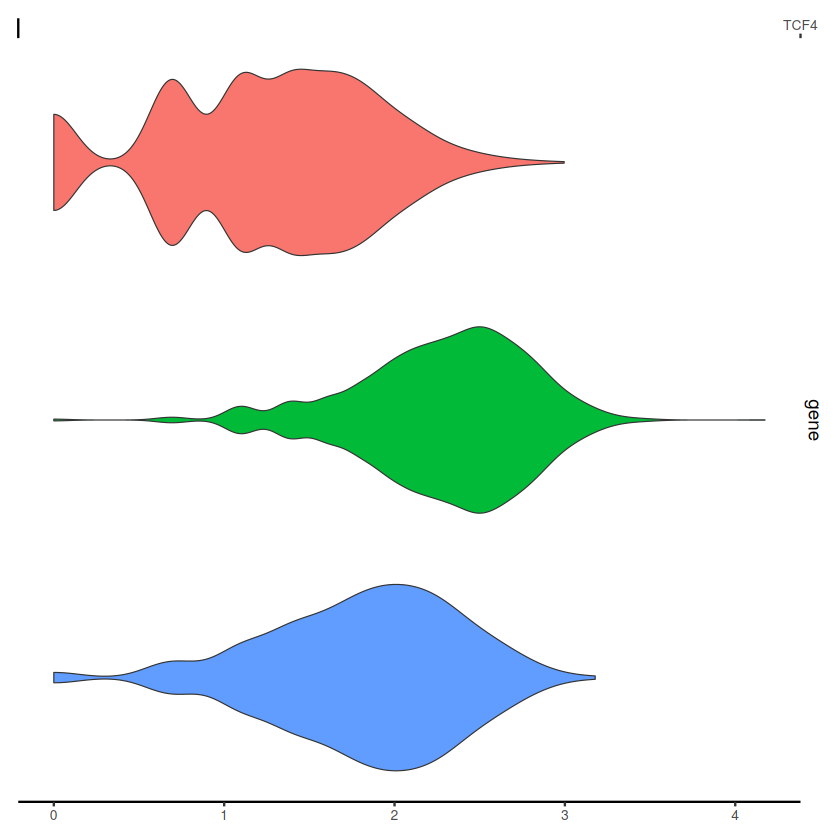

In [10]:
expr_plot <- ExpressionPlot(
  object = seurat_object,
  features = "TCF4",
  assay = "SCT",
)
expr_plot

In [11]:
# start and end coords of the region of interest (chr18:55186072-55762857)
start_coord <- 55186072
end_coord <- 55762857

In [12]:
plot_regulatory_regions <- function(regulatory_regions, start_coord, end_coord) {
  
  # Debug output
  print("Function called with:")
  print(paste("start_coord:", start_coord))
  print(paste("end_coord:", end_coord))
  print("Regulatory regions:")
  print(regulatory_regions)
  
  y_base <- 0
  line_length <- 0.5
  text_spacing <- 0.2
  
  # Sort regions by start position
  regulatory_regions <- regulatory_regions[order(regulatory_regions$start),]
  
  # Initialize positions
  regulatory_regions$y_pos <- 0
  regulatory_regions$level <- 0
  
  # Assign levels to avoid overlap
  for (i in 1:nrow(regulatory_regions)) {
    overlap <- TRUE
    level <- 0
    while (overlap) {
      level <- level + 1
      overlap <- any(regulatory_regions$level[1:(i-1)] == level & 
                     abs(regulatory_regions$start[1:(i-1)] - regulatory_regions$start[i]) < (end_coord - start_coord) / 50)
    }
    regulatory_regions$level[i] <- level
  }
  
  # Assign y positions based on levels
  max_level <- max(regulatory_regions$level)
  regulatory_regions$y_pos <- ifelse(regulatory_regions$level %% 2 == 1,
                                     regulatory_regions$level / max_level,
                                     -regulatory_regions$level / max_level)
  
  # Debug output
  print("After processing:")
  print(regulatory_regions)
  
  p <- ggplot() +
    geom_segment(aes(x = start_coord, xend = end_coord, y = y_base, yend = y_base),
                 color = "black", size = 0.5) +
    geom_segment(data = regulatory_regions, 
                 aes(x = start, xend = end, y = y_base, yend = y_base, color = type),
                 size = 2) +
    geom_segment(data = regulatory_regions,
                 aes(x = (start + end)/2, xend = (start + end)/2,
                     y = y_base, yend = y_pos * (line_length + text_spacing),
                     color = type),
                 size = 0.5) +
    geom_text(data = regulatory_regions, 
              aes(x = (start + end)/2, 
                  y = y_pos * (line_length + text_spacing * 1.5),
                  label = name, 
                  color = type), 
              hjust = 0.5,
              vjust = ifelse(regulatory_regions$y_pos > 0, 0, 1),
              size = 3, angle = 90) +
    scale_color_manual(values = c(Activating = "#006400", Repressing = "red")) +
    scale_x_continuous(limits = c(start_coord, end_coord)) +
    scale_y_continuous(limits = c(-1, 1)) +
    theme_minimal() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          panel.grid = element_blank(),
          legend.position = "bottom") +
    labs(x = "Genomic position")
  
  print("Plot created")
  
  return(p)
}

In [13]:
# no labels
plot_regulatory_regions <- function(regulatory_regions, start_coord, end_coord) {
  
  # Debug output
  print("Function called with:")
  print(paste("start_coord:", start_coord))
  print(paste("end_coord:", end_coord))
  print("Regulatory regions:")
  print(regulatory_regions)
  
  y_base <- 0
  line_length <- 0.5
  
  # Sort regions by start position
  regulatory_regions <- regulatory_regions[order(regulatory_regions$start),]
  
  # Initialize positions
  regulatory_regions$y_pos <- 0
  regulatory_regions$level <- 0
  
  # Assign levels to avoid overlap
  for (i in 1:nrow(regulatory_regions)) {
    overlap <- TRUE
    level <- 0
    while (overlap) {
      level <- level + 1
      overlap <- any(regulatory_regions$level[1:(i-1)] == level & 
                     abs(regulatory_regions$start[1:(i-1)] - regulatory_regions$start[i]) < (end_coord - start_coord) / 50)
    }
    regulatory_regions$level[i] <- level
  }
  
  # Assign y positions based on levels
  max_level <- max(regulatory_regions$level)
  regulatory_regions$y_pos <- ifelse(regulatory_regions$level %% 2 == 1,
                                     regulatory_regions$level / max_level,
                                     -regulatory_regions$level / max_level)
  
  # Debug output
  print("After processing:")
  print(regulatory_regions)
  
  p <- ggplot() +
    geom_segment(aes(x = start_coord, xend = end_coord, y = y_base, yend = y_base),
                 color = "black", size = 0.5) +
    geom_segment(data = regulatory_regions, 
                 aes(x = start, xend = end, y = y_base, yend = y_base),
                 color = "#006400", size = 2) +
    geom_segment(data = regulatory_regions,
                 aes(x = (start + end)/2, xend = (start + end)/2,
                     y = y_base, yend = y_pos * line_length),
                 color = "#006400", size = 0.5) +
    scale_x_continuous(limits = c(start_coord, end_coord)) +
    scale_y_continuous(limits = c(-1, 1)) +
    theme_minimal() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          panel.grid = element_blank(),
          legend.position = "none") +
    labs(x = "Genomic position")
  
  print("Plot created")
  
  return(p)
}

In [44]:
# no labels
plot_regulatory_regions_nl <- function(regulatory_regions, start_coord, end_coord) {
  
  # Debug output
  print("Function called with:")
  print(paste("start_coord:", start_coord))
  print(paste("end_coord:", end_coord))
  print("Regulatory regions:")
  print(regulatory_regions)
  
  y_base <- 0
  line_length <- 0.5
  
  # Sort regions by start position
  regulatory_regions <- regulatory_regions[order(regulatory_regions$start),]
  
  # Initialize positions
  regulatory_regions$y_pos <- 0
  regulatory_regions$level <- 0
  
  # Assign levels to avoid overlap
  for (i in 1:nrow(regulatory_regions)) {
    overlap <- TRUE
    level <- 0
    while (overlap) {
      level <- level + 1
      overlap <- any(regulatory_regions$level[1:(i-1)] == level & 
                     abs(regulatory_regions$start[1:(i-1)] - regulatory_regions$start[i]) < (end_coord - start_coord) / 50)
    }
    regulatory_regions$level[i] <- level
  }
  
  # Assign y positions based on levels
  max_level <- max(regulatory_regions$level)
  regulatory_regions$y_pos <- ifelse(regulatory_regions$level %% 2 == 1,
                                     regulatory_regions$level / max_level,
                                     -regulatory_regions$level / max_level)
  
  # Debug output
  print("After processing:")
  print(regulatory_regions)
  
  p <- ggplot() +
    geom_segment(aes(x = start_coord, xend = end_coord, y = y_base, yend = y_base),
                 color = "black", size = 0.5) +
    geom_segment(data = regulatory_regions, 
                 aes(x = start, xend = end, y = y_base, yend = y_base),
                 color = "#006400", size = 2) +
    geom_segment(data = regulatory_regions,
                 aes(x = (start + end)/2, xend = (start + end)/2,
                     y = y_base, yend = y_pos * line_length),
                 color = "#006400", size = 0.5) +
    scale_x_continuous(limits = c(start_coord, end_coord)) +
    scale_y_continuous(limits = c(-1, 1)) +
    theme_minimal() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          panel.grid = element_blank(),
          legend.position = "none") +
    labs(x = "Genomic position")
  
  print("Plot created")
  
  return(p)
}

In [19]:
# aggr close regions
plot_regulatory_regions <- function(regulatory_regions, start_coord, end_coord) {
  y_base <- 0
  line_length <- 0.5
  
  # Sort regions by start position
  regulatory_regions <- regulatory_regions[order(regulatory_regions$start),]
  
  # Initialize positions
  regulatory_regions$y_pos <- 0
  regulatory_regions$level <- 0
  
  # Assign levels to avoid overlap, limiting to 2 levels
  for (i in 1:nrow(regulatory_regions)) {
    overlap_above <- any(regulatory_regions$level[1:(i-1)] == 1 & 
                         abs(regulatory_regions$start[1:(i-1)] - regulatory_regions$start[i]) < (end_coord - start_coord) / 50)
    overlap_below <- any(regulatory_regions$level[1:(i-1)] == -1 & 
                         abs(regulatory_regions$start[1:(i-1)] - regulatory_regions$start[i]) < (end_coord - start_coord) / 50)
    
    if (!overlap_above) {
      regulatory_regions$level[i] <- 1
    } else if (!overlap_below) {
      regulatory_regions$level[i] <- -1
    } else {
      regulatory_regions$level[i] <- 0  # Skip this region if both levels are occupied
    }
  }
  
  # Filter out skipped regions
  regulatory_regions <- regulatory_regions[regulatory_regions$level != 0, ]
  
  # Assign y positions based on levels
  regulatory_regions$y_pos <- regulatory_regions$level
  
  p <- ggplot() +
    geom_segment(aes(x = start_coord, xend = end_coord, y = y_base, yend = y_base),
                 color = "black", size = 0.5) +
    geom_segment(data = regulatory_regions, 
                 aes(x = start, xend = end, y = y_base, yend = y_base),
                 color = "#006400", size = 2) +
    geom_segment(data = regulatory_regions,
                 aes(x = (start + end)/2, xend = (start + end)/2,
                     y = y_base, yend = y_pos * line_length),
                 color = "#006400", size = 0.5) +
    scale_x_continuous(limits = c(start_coord, end_coord)) +
    scale_y_continuous(limits = c(-1, 1)) +
    theme_minimal() +
    theme(axis.title.y = element_blank(),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
          panel.grid = element_blank(),
          legend.position = "none") +
    labs(x = "Genomic position")
  
  return(p)
}

In [20]:
p_regulatory <- plot_regulatory_regions(regulatory_regions_activating, start_coord, end_coord)

Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


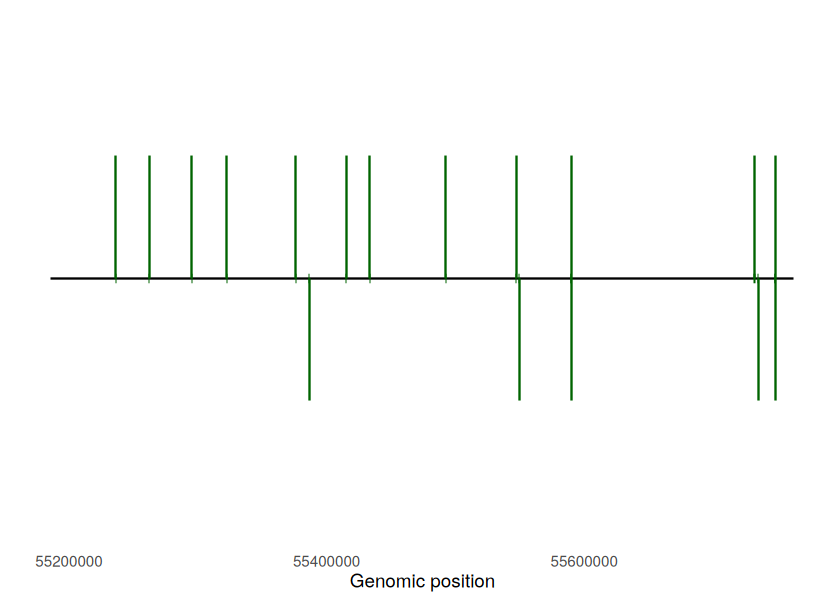

In [21]:
p_regulatory

Warning message:
“Removed 5 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


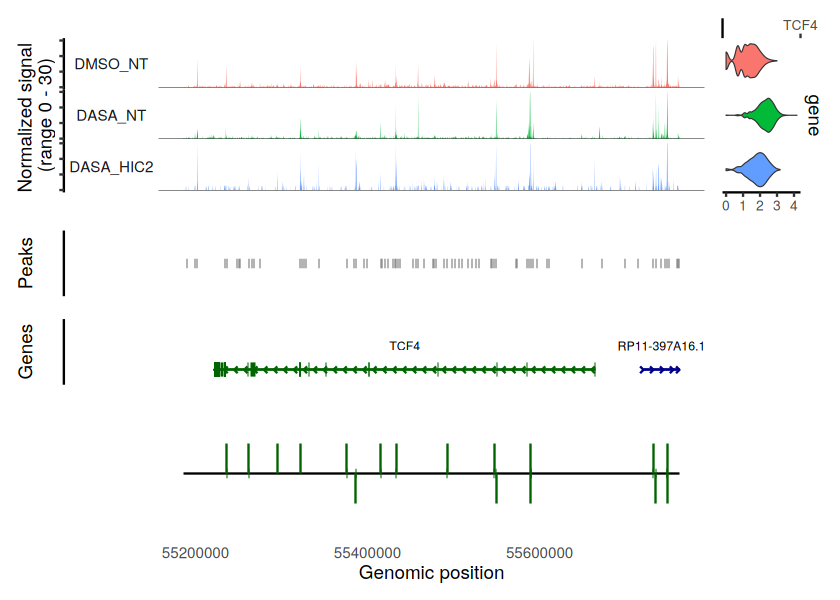

In [22]:
options(repr.plot.width=7, repr.plot.height=5)  # Increased width slightly

# Increase font size for all plots
theme_update(text = element_text(size = 14))  # Adjust the size value as needed

final_plot <- CombineTracks(
    plotlist = list(cov_plot, peak_plot, gene_plot, p_regulatory),
    expression.plot = expr_plot,
    heights = c(2, 1, 1, 2),  
    widths = c(7, 1)
) 

# # Apply the updated theme to the final plot
# final_plot <- final_plot + theme(text = element_text(size = 14))

final_plot

# Zoom in on the region

In [31]:
cov_plot <- CoveragePlot(
  object = seurat_object,
  region = "chr18-55724121-55741164",
  annotation = FALSE,
  peaks = FALSE,
  links = FALSE,
  # extend.upstream = 5000,
  # extend.downstream = 5000,
  ymax = 30
)
peak_plot <- PeakPlot(
  object = seurat_object,
  region = "chr18-55724121-55741164"
)

gene_plot <- AnnotationPlot(
  object = seurat_object,
  region = "chr18-55724121-55741164"
)

link_plot <- LinkPlot(
  object = seurat_object,
  region = "chr18-55724121-55741164"
)

expr_plot <- ExpressionPlot(
  object = seurat_object,
  features = "TCF4",
  assay = "SCT",
)

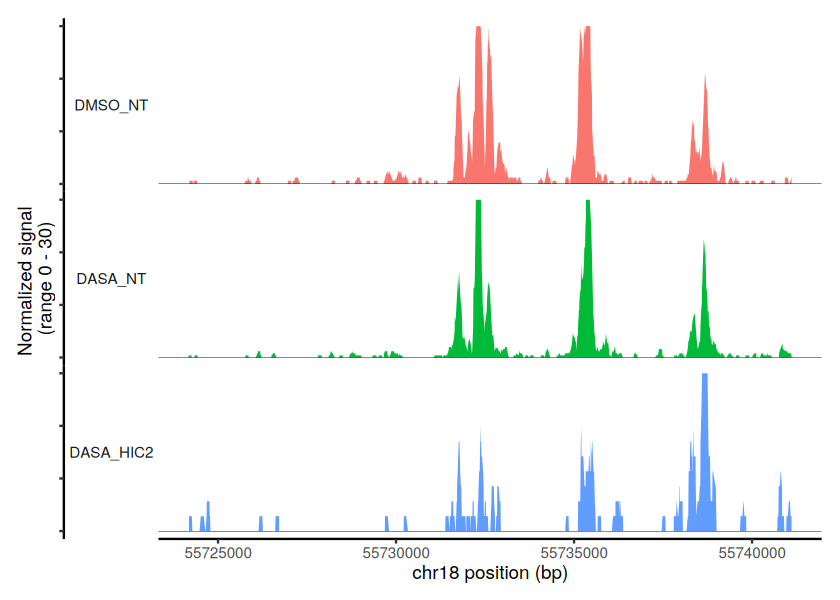

In [32]:
cov_plot

In [33]:
# start and end coords of the region of interest (chr18:55186072-55762857)
start_coord <- 55724121
end_coord <- 55741164

In [45]:
p_regulatory <- plot_regulatory_regions_nl(regulatory_regions_activating, start_coord, end_coord)

[1] "Function called with:"
[1] "start_coord: 55724121"
[1] "end_coord: 55741164"
[1] "Regulatory regions:"
      start      end       type    name
5  55235918 55236927 Activating   KLF13
6  55261775 55262816 Activating  ZNF117
8  55295048 55295939 Activating  ZNF33B
10 55322346 55322861 Activating   ZFPM2
12 55375696 55376626 Activating    MXD4
14 55386395 55387235 Activating   ZFPM2
16 55415055 55415969 Activating   MEF2A
19 55433174 55434244 Activating   NFAT5
27 55492395 55493349 Activating   ZFPM1
34 55546935 55547847 Activating   MEF2A
38 55549197 55550134 Activating ZNF518A
40 55589847 55590355 Activating  ZNF148
41 55589847 55590355 Activating   TFDP2
52 55731883 55732808 Activating   ZFPM2
54 55734861 55735820 Activating    TAL1
56 55734861 55735820 Activating   ZFPM1
58 55738171 55739061 Activating   ZFPM2
60 55738171 55739061 Activating   SMAD6
66 55748041 55748974 Activating   ZFPM2
69 55748041 55748974 Activating  ZNF431
70 55748041 55748974 Activating  ZNF708
74 55749952 

Warning message:
“Removed 11 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 19 rows containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 19 rows containing missing values or values outside the scale range
(`geom_segment()`).”


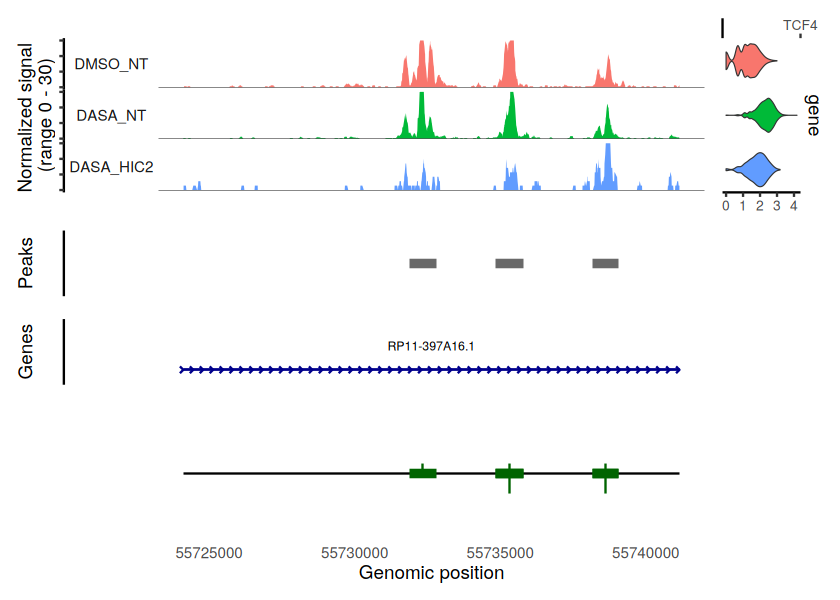

In [46]:
options(repr.plot.width=7, repr.plot.height=5)  # Increased width slightly

# Increase font size for all plots
theme_update(text = element_text(size = 14))  # Adjust the size value as needed

final_plot <- CombineTracks(
    plotlist = list(cov_plot, peak_plot, gene_plot, p_regulatory),
    expression.plot = expr_plot,
    heights = c(2, 1, 1, 2),  
    widths = c(7, 1)
) 

# # Apply the updated theme to the final plot
# final_plot <- final_plot + theme(text = element_text(size = 14))

final_plot